In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import IPython
import pyroomacoustics as pra

(2, 4)
[[0.  0.  2.2 2.2]
 [0.  1.1 1.1 0. ]]


(-0.1, 1.2)

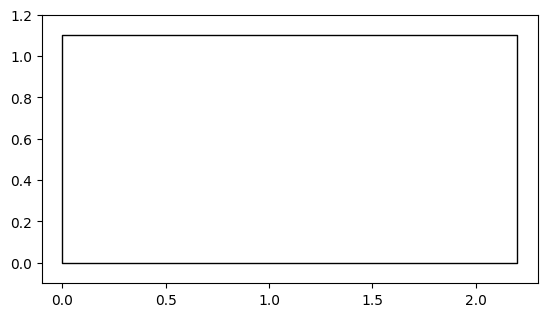

In [4]:
# 创建 2D 房间节点（顺时针旋转）
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T
print(corners.shape)
print(corners)

# 由 2D 空间节点构建 2D 房间
room = pra.Room.from_corners(corners)

# 绘制 2D 房间
fig, ax = room.plot()
ax.set_xlim([-0.1, 2.3])
ax.set_ylim([-0.1, 1.2])

In [5]:
# room.extrude(1.2)

# fig, ax = room.plot()
# ax.set_xlim([-0.2, 2.22])
# ax.set_ylim([-0.1, 1.11])
# ax.set_zlim([-0.1, 1.21])

为了仿真声音在房间的传播需要进行以下几个步骤的设置：

- (1) 创建房间模型
- (2) 添加声源和麦克风
- (3) 房间脉冲响应（RIR）生成器与传播仿真

(1, 963024)


<Figure size 640x480 with 0 Axes>

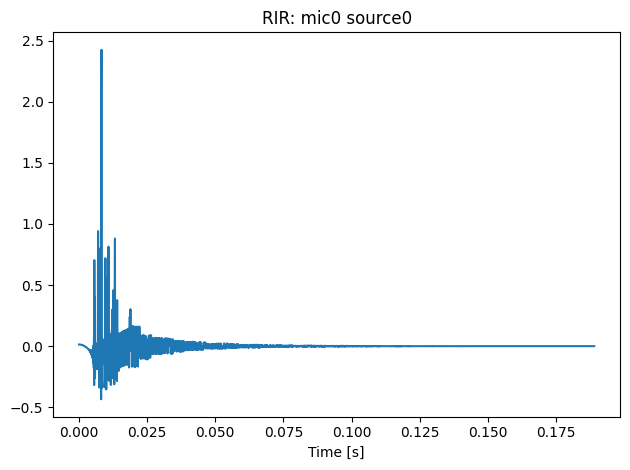

In [32]:
# 原始噪声信号
fs, Noise_Source = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 向房间中添加信号源，首先构造一个 2D 房间，并设置房间的频率属性、ray_tracing、空气吸收率（air_absorption），最大阶数（max_order）、材料（materials）参数进行设置，并生成新的 2D 房间 room 对象
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15), air_absorption=True)

# 使用 extrude() 方法构造 3D 房间
room.extrude(1.2, materials=pra.Material(0.2, 0.15))

# 设置 ray tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 使用 add_source() 方法在 [0.02, 0.55] 处添加信号源 signal
room.add_source([0.02, 0.55, 0.6], signal=Noise_Source)

# 同样下面添加麦克风，这个麦克风的音源是经过滤波器处理后的噪声信号，所以这里将其放到滤波器训练之后再添加，而且不应该添加麦克风，应该添加声源
# room.add_microphone([2.18, 0.55, 0.6], fs)

# 下面在房子中心添加一个误差麦克风
room.add_microphone([1.1, 0.55, 0.6], fs)

# 使用 image_source_model() 类方法计算房间 room 的麦克风脉冲响应
room.image_source_model()

# 绘制房间和信号源，目前不清楚这个图为什么绘制不出来？
fig, ax = room.plot()

# 使用 room 的 plot_rir() 类方法绘制麦克风的 RIR
room.plot_rir()

fig = plt.gcf()

# 对房间进行仿真
room.simulate()
print(room.mic_array.signals.shape)

# 下面设计滤波器
# 滤波器参数
length = 15
# n_samples = 40000
n_samples = len(Noise_Source)

# 设置滤波器参数
w  = np.random.randn(length) # 设置滤波器权重参数
w /= np.linalg.norm(w)       # 对滤波器参数进行范数正则化处理

d = fftconvolve(Noise_Source, w)[:n_samples]

# 滤波器算法1：RLS滤波算法
# filter_rls = dict(
#     filter = pra.adaptive.RLS(length, lmbd=0.999, delta=7.),
#     error = np.zeros(n_samples),
# )

# 滤波器算法2：NLMS 滤波算法
filter_nlms = dict(
    filter = pra.adaptive.NLMS(length, mu=0.5),
    error  = np.zeros(n_samples),
)

# 滤波器算法3：BLOCK_RLS 算法
# filter_block_rls = dict(
#     filter=pra.adaptive.BlockRLS(length, lmbd=1., delta=2.0),
#     error=np.zeros(n_samples),
# )

# 滤波器参数迭代更新
for i in range(n_samples):
    filter_nlms["filter"].update(Noise_Source[i], d[i])
    filter_nlms["error"][i] = np.linalg.norm(filter_nlms["filter"].w - w)

# 经过训练后的滤波器的第二通道信号
# Noise_S_RLS = fftconvolve(Noise_Source, w)    # RLS 算法
Noise_S_NLMS = fftconvolve(Noise_Source, w)     # NLMS 算法
# Noise_S_BLOCK_RLS = fftconvolve(Noise_Source, w)     # BLOCK_RLS 算法

# room.add_microphone([2.18, 0.55, 0.6], fs)

# 将经过优化后的滤波器的噪声信号作为声源，添加到第二通道处
# room.add_source([2.18, 0.55, 0.6], signal=Noise_S_RLS)  # 基于 RLS 算法的模型
room.add_source([2.18, 0.55, 0.6], signal=Noise_S_NLMS)  # 基于 NLMS 算法的模型



In [33]:
print("Original WVA:")
IPython.display.Audio(Noise_Source, rate=fs)

Original WVA:


In [34]:
print("误差麦克风处的输出:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

误差麦克风处的输出:


In [35]:
print("第二通道处的噪声源信号:")
IPython.display.Audio(Noise_S_NLMS, rate=fs)

第二通道处的噪声源信号:


/tmp/ipykernel_22299/3163455356.py:78: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
/tmp/ipykernel_22299/3163455356.py:81: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


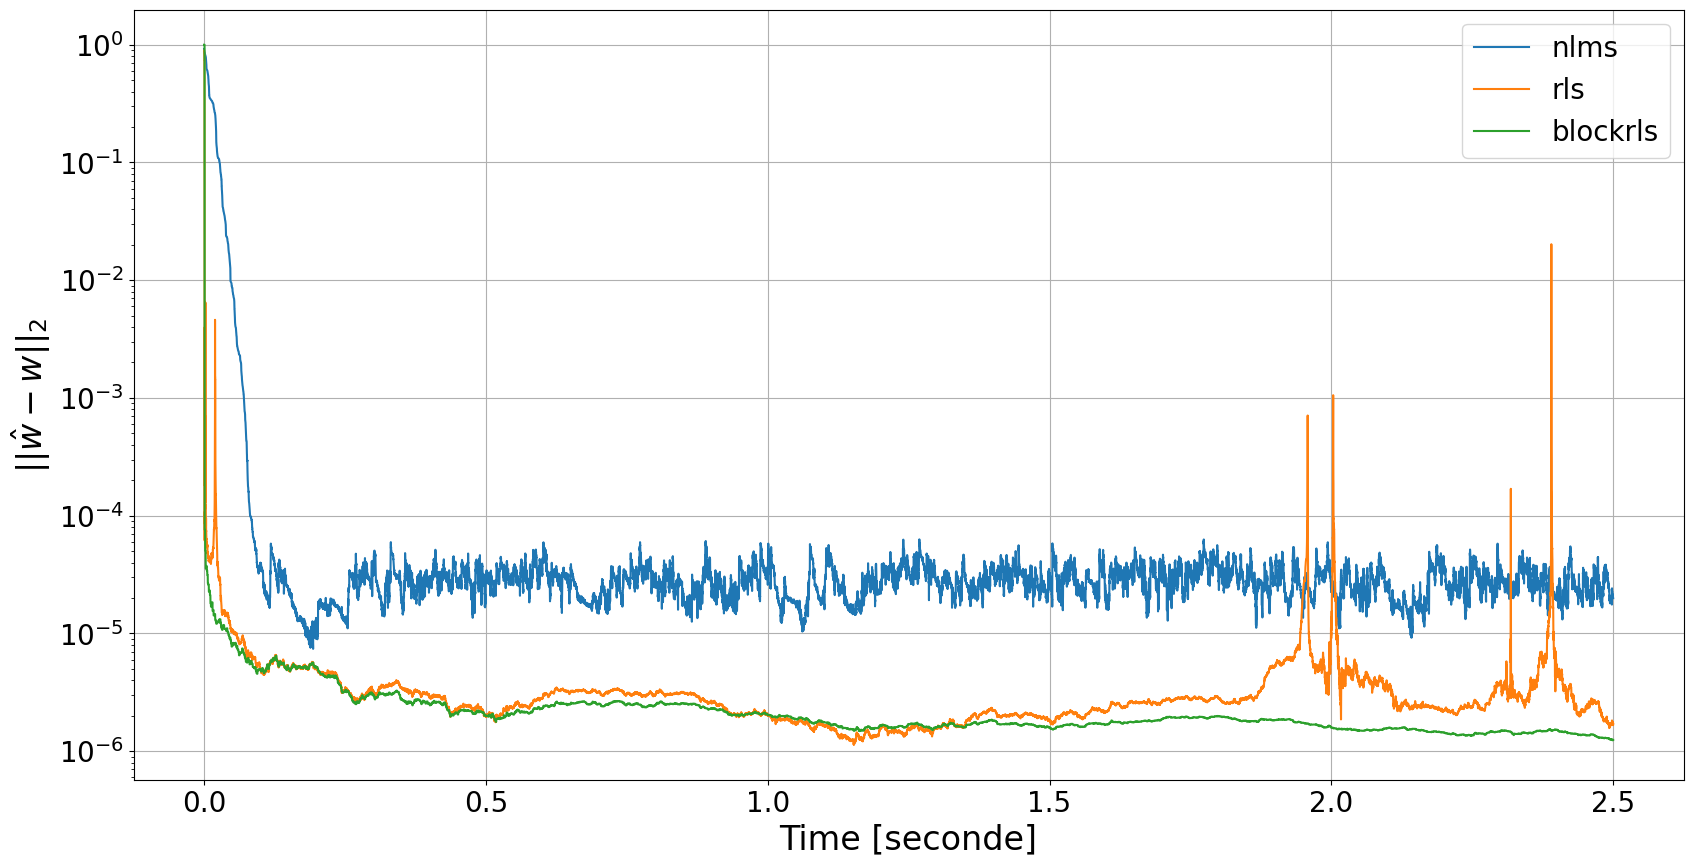

In [9]:
# 使用 wavfile.read方法读取 arctic_10001.wav 音频数据，并返回频率 fs 和信号 signal 数据

# 原始噪声信号
# fs, signal_first_channel = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 下面设置自适应滤波器
# 滤波器参数
length = 15
n_samples = 40000
# fs 这里不用设置，因为读取信号的时候已经确定
SNR = 10

x = Noise_Source[:n_samples]

# 设置随机滤波器参数
w = np.random.randn(length) # 滤波器权重参数
w /= np.linalg.norm(w)      # 对滤波器参数进行范数正则化处理

# 第二个通道信号（用于抵消原始噪声）
# signal_second_channel = fftconvolve(signal_firt_channel, w)[:n_samples]

# signal_second_channel = signal_second_channel + np.random.randn(n_samples) * 10 ** (-SNR / 20.)

# signal_second_channel = room.mic_array.signals[0,:]

# signal_second_channel = fftconvolve(room.mic_array.signals[0,:], w)[:n_samples]

d = fftconvolve(x, w)[:n_samples] + np.random.randn(n_samples) * 10 ** (-SNR / 20.)

# NLMS 滤波器
# filter = dictgoogle_speech_commands/bed/0a7c2a8d_nohash_0.wav(
#     filter = pra.adaptive.BlockRLS(length, lmbd=1., delta=2.0),
#     error  = np.zeros(n_samples),
# )

adfilt = dict(
    # lms=dict(
    #     filter = pra.adaptive.lms(length),
    #     error = np.zeros(n_samples),
    # ),
    nlms=dict(
        filter = pra.adaptive.NLMS(length, mu=0.5),
        error  = np.zeros(n_samples),
    ),
    # blocklms=dict(
    #     filter=pra.adaptive.BlockLMS(length, mu=1./10./2.),
    #     error=np.zeros(n_samples),
    # ),
    rls=dict(
        filter=pra.adaptive.RLS(length, lmbd=0.9999, delta=7.),
        error=np.zeros(n_samples),
    ),
    blockrls=dict(
        filter=pra.adaptive.BlockRLS(length, lmbd=1., delta=2.0),
        error=np.zeros(n_samples),
    ),
)

# 滤波器参数迭代更新
for i in range(n_samples):
    for algo in adfilt.values():
        algo["filter"].update(x[i], d[i])
        algo["error"][i] = np.linalg.norm(algo["filter"].w - w)

# 绘图
plt.figure()

for algo in adfilt.values():
    plt.semilogy(np.arange(n_samples) / fs, algo["error"])

plt.legend(adfilt, fontsize=20)
plt.ylabel("$\||\hat{w}-w\||_2$", fontsize=24)
plt.xlabel("Time [seconde]", fontsize=24)

# 设置坐标轴刻度的字体大小
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

plt.grid()
fig = plt.gcf()
fig.set_size_inches(20, 10)



### 下面构造深度学习音频数据集



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import pywt
from scipy.io import loadmat
import os
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

import os
from PIL import Image

import gc

# 读取数据集名称，用于后续逐条读取噪声数据的内容
filenames = os.listdir('../input/noisex92/NOISEX-92_mat/')
filenames

# 定义一个capture函数通过loadmat方法读取数据集中的噪声函数，并将其放入files变量中
d_path = '../input/noisex92/NOISEX-92_mat/'

def capture(d_path):
    files = {}
    for i in filenames:
        file_path = os.path.join(d_path, i)
        file = loadmat(file_path)
        file_keys = file.keys()
        for key in file_keys:
            if '_' not in key:
                # 将文件名的.mat去掉，并将噪声数据变成一维向量
                files[i[:-4]] = file[key].ravel()
    return files

# 调用capture函数读取噪声数据
noise_data = capture(d_path)

# 下面查看读取数据的信息

# 查看noise_data数据包含的噪声类型
print(noise_data.keys())

# 查看每种噪声的数据长度
for i in noise_data.keys():
    print(noise_data[i].shape)
    
# 查看每种噪声对应的值
for i in noise_data.keys():
    print(noise_data[i])
    
# 对其中一种噪声进行绘图，直观感受一下
plt.plot(noise_data['babble'])



ModuleNotFoundError: No module named 'pywt'

下面构造slice_enc函数对读取的噪声数据noise_data（字典格式存储）进行数据拆分，以便后续的深度学习建模

In [ ]:
def slice_enc(data, slice_length, slice_num):
    Slice_Samples = {}
    
    for i in data.keys():
        slice_data = data[i]
        slice_sample = []
        
        for j in range(slice_num):
            slice_sample.append(slice_data[j*slice_length : (j+1)*slice_length])
            
        Slice_Samples[i] = slice_sample
        
    return Slice_Samples

# 下面将每种噪声切分为90块，且每块的长度为50000个噪声数据点，并将数据存储到Slice_Samples
Slice_Samples = slice_enc(noise_data, 50000, 90)

# 查看其中一个种类的噪声切分后的数据。比如factory1的噪声数据，它由原来的一维转变为二维的：
# 共分为90组，每组具有50000个噪声数据点
Slice_Samples['factory1']


: 

下面编写正则化函数对Slice_Samples（以字典格式存储）中的噪声数据进行正则化处理


In [ ]:
def scalar_stand(Train_X):
    for i in Train_X.keys():
        scalar = preprocessing.StandardScaler().fit(Train_X[i])
        Train_X[i] = scalar.transform(Train_X[i])
        
    return Train_X

# 使用scalr_stand函数对Slice_Samples进行正则化
Slice_Samples_Scalar = scalar_stand(Slice_Samples)

# 查看正则化后的结果，以facotry1为例
Slice_Samples_Scalar['factory1']

: 

下面对正则化处理的切分后的噪声数据进行小波变换，并将变换后的图片存储到对应的文件夹内

In [ ]:
Slice_Samplesnoise_type2num = {
    'factory1': 1,
    'buccaneer2': 2,
    'pink': 3,
    'factory2': 4,
    'destroyerengine': 5,
    'babble': 6,
    'f16': 7,
    'machinegun': 8,
    'hfchannel': 9,
    'buccaneer1': 10,
    'm109': 11,
    'white': 12,
    'destroyerops': 13,
    'leopard': 14,
    'volvo': 15
}

Slice_Samplesnoise_type2num

for noise in Slice_Samples_Scalar.keys():
    print(noise)

: 

In [ ]:
fs = 19980
# 原始信号的小波变换
# signal = files['factory1'][0:50000]

# 小波类型
wavename = 'cmor3-3'
# wavename = 'gaus1'
# wavename = 'cgau8'

# 小波变换参数设置
totalscale = 256
fc = pywt.central_frequency(wavename)
cparam = 2 * fc * totalscale
scales = cparam / np.arange(totalscale, 1, -1)

# 时间轴设置
signal_temp = Slice_Samples_Scalar['pink'][0]
t = np.linspace(0, signal_temp.size / fs, signal_temp.size, endpoint=False)

for noise_type in Slice_Samples_Scalar.keys():
    for i in range(0, 89):
        # 获取噪声信号
        # 正则化后的信号的小波变换
        signal = Slice_Samples_Scalar[noise_type][i]

        # 对噪声信号进行小波变换
        [cwtmatr, freqencies] = pywt.cwt(signal, scales, wavename, 1.0 / fs)
        plt.contour(t, freqencies, abs(cwtmatr))
        # plt.show()

        plt.axis('off')
        plt.gcf().set_size_inches(8, 8)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0, 0)

        # 存储图片的位置
        x = r'./' + str(i+1) + '-' + noise_type + '.jpg'
        plt.savefig(x)

        # 内存优化
        del signal
        del x
        gc.collect()

: 

下面读取小波变换后的图片，并对图片进行预处理，然后获取训练数据。

In [ ]:
# 图片存放的文件路径，在kaggle中./表示读取/kaggle/working中的数据
figure_path = './'

def read_directory(directory_name, height, width, normal):
    file_list = os.listdir(directory_name)
    file_list.sort(key=lambda x: int(x.split("-")[0]))
    img = []
    label0 = []
    
    for each_file in file_list:
        # 读取图片
        img0 = Image.open(directory_name + "/" + each_file)
        # 将图片转换为灰色图片
        img0 = img0.convert("L")
        # 改变图片像素
        gray = img0.resize((100, 100))
        # 将读取的图片转换np格式的数据，并存储到img列表中
        img.append(np.array(gray).astype(np.float32))
        label0.append(noise_type2num[each_file.split('-')[1].split('.')[0]])
        print(each_file)
        
    if normal:
        data = np.array(img) / 255.0
    else:
        data = np.array(img)
        
    # 下面指令是针对tensorflow的形状变换，后续根据需要
    # 下面每个每个维度的含义为图片的(数量，通道数，高，长)
    data = data.reshape(-1, 1, height, width)
    label = np.array(label0)
    
    return data, label

# 下面调用read_directory函数读取相应文件夹中的图片
data, label = read_directory(figure_path, 100, 100, 0)
        

: 